In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import pandas as pd
from pandas.io.json import json_normalize
import json
import datetime
import statsmodels.api as sm
from statsmodels.tsa import stattools
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa import ar_model
from statsmodels.tsa.arima_model import ARIMA

In [270]:
meanRow = [-1.49283777, -1.4599206,  -1.43553526, -1.41048629, -1.38650273, -1.36304799,
 -1.33997846, -1.31721066, -1.29183494, -1.26405501, -1.234513,   -1.20597086,
 -1.18041702, -1.15397495, -1.12776921, -1.10389011, -1.08048908, -1.06333912,
 -1.05066557, -1.0314661,  -1.00804651, -0.98297053, -0.95568661, -0.92830357,
 -0.90287162, -0.87896379, -0.85258824, -0.82252028, -0.7877091,  -0.75416743,
 -0.72705308, -0.70336159, -0.67714437, -0.64534325, -0.61499754, -0.58811094,
 -0.56135151, -0.53112621, -0.50292386, -0.48587099, -0.46537928, -0.43646908,
 -0.40913074, -0.38249728, -0.35624645, -0.33012444, -0.30499109, -0.27935266,
 -0.24732316, -0.21253605, -0.1828706,  -0.15393715, -0.12211321, -0.09252632,
 -0.06193811, -0.02878588,  0.00389883,  0.03843641,  0.07536602,  0.11391066,
  0.15016588,  0.18328591,  0.21498509,  0.24624267,  0.27784464,  0.31301262,
  0.35600539,  0.39882603,  0.43669349,  0.46428461,  0.48191794,  0.50850308,
  0.54657576, 0.58565816,  0.62412884,  0.66156217,  0.69924316,  0.7406236,
  0.78313939,  0.82228294,  0.8593403,   0.8925276,   0.92941464,  0.97622255,
  1.02550946, 1.06566618 , 1.09827972,  1.13354852,  1.17758223,  1.22346988,
  1.26843863,  1.32099305,  1.36839343,  1.41063075,  1.45468962,  1.50121955,
  1.54659139,  1.59447007,  1.64445519,  1.68826189,  1.72735929,  1.76720979,
  1.81047771,  1.85568521,  1.90420733]

mean = TimeSeriesScalerMeanVariance(mu=0. , std=1.).fit_transform(pd.Series(meanRow[53:])).flatten()
mean

array([-1.59204141, -1.53993619, -1.48346331, -1.42778682, -1.36895408,
       -1.30604665, -1.24038812, -1.17862948, -1.12221145, -1.06821375,
       -1.0149683 , -0.96113619, -0.9012296 , -0.82799394, -0.75505149,
       -0.69054649, -0.64354663, -0.61350929, -0.56822306, -0.50336848,
       -0.4367939 , -0.37126136, -0.30749587, -0.24330852, -0.17281936,
       -0.10039621, -0.03371746,  0.02940758,  0.0859402 ,  0.14877511,
        0.22850964,  0.312467  ,  0.38087162,  0.43642687,  0.49650521,
        0.57151405,  0.64968097,  0.7262826 ,  0.81580598,  0.89654974,
        0.96849854,  1.04355025,  1.12281125,  1.20009952,  1.28165805,
        1.36680477,  1.44142692,  1.50802705,  1.57591004,  1.6496144 ,
        1.72662273,  1.80927732])

In [389]:
def convert_datetime(name):
    json = pd.read_json('../data/downloads/' + name + '_download.json')
    df_json = pd.DataFrame(json['downloads'])
    df = json_normalize(df_json['downloads'])
    df['day'] = pd.to_datetime(df['day'], infer_datetime_format=True)
    df.index = df['day']
    return df

def convert_star_week_datatime(name):
  name = name.split('/')
  fname = 'data/stars/' + name[0] +'_' + name[1] + '_stars.json'
  pkg = pd.read_json(fname)
  pkg = pd.Series(pd.to_datetime(pkg['staredAts'])).dt.date
  github_life = np.arange('2016-09-04', '2019-09-02', dtype='datetime64[D]')
  github_life = pd.Series(github_life, name='t').dt.date
  star_counts = []
  for d in github_life:
    count = pkg[pkg == d].count()
    star_counts.append(count)
  starsCount = pd.Series(star_counts, index=pd.date_range('2016-09-04', '2019-09-01'))
  return round(starsCount.resample(rule='W').mean())

def convert_week_datetime(name):
    df = convert_datetime(name)
    df_w = round(df.resample(rule="W").mean())
    return df_w

def convert_ts(name):
    df_w = convert_week_datetime(name)
    ts = sm.tsa.seasonal_decompose(df_w['downloads'].values, freq=52)
    return ts

def convert_arima(name):
    df_w = convert_week_datetime(name)
    v = df_w['downloads']
    v104 = v[:104].values
    ts = sm.tsa.seasonal_decompose(v104, freq=52)
    seri = pd.Series(ts.trend).dropna()
    seri = pd.Series(seri.values)
    model_d0 = ARIMA(seri, (5, 2, 1))
    results_d0 = model_d0.fit()
    res_d0 = results_d0.resid
    ts = sm.tsa.seasonal_decompose(v.values, freq=52)
    gens = pd.Series(ts.trend).dropna()
    gens = pd.Series(gens.values)
    plt.figure()
    plt.title(name)
    plt.plot(gens, label='observation')
    plt.plot(results_d0.predict(2, len(gens), typ="levels").values, 
         '--', label='forecast')
    plt.show()
    
def is_sucess(name):
#     print(name)
    df_w = convert_week_datetime(name)
    v = df_w['downloads']
    #  配列化
    v104 = v[:104].values
    vFuture = v[104:156].values
    #  季節調整
    ts104 = sm.tsa.seasonal_decompose(v104, freq=52)
    tsActual = sm.tsa.seasonal_decompose(v.values, freq=52)
    #   欠損のカット
    ts104TrendSeries = pd.Series(pd.Series(ts104.trend).dropna().values)
    actualTrendSeries = pd.Series(pd.Series(tsActual.trend).dropna().values)
    #   標準化後、配列に
    sdTs104Trend = TimeSeriesScalerMeanVariance(mu=0. , std=1.).fit_transform(ts104TrendSeries.values).flatten()
    sdActualTrend = TimeSeriesScalerMeanVariance(mu=0. , std=1.).fit_transform(pd.Series(actualTrendSeries[53:].values)).flatten()
    preDistans = np.linalg.norm(sdTs104Trend - mean)
    actualDistans = np.linalg.norm(sdActualTrend - mean)
    
    settingBoarderNum = 13

#     print('104', preDistans < settingBoarderNum)
#     print('actual', actualDistans < settingBoarderNum)
    
    model = ARIMA(ts104TrendSeries.values, (5, 2, 1))
    result = model.fit()
    predict = result.predict(2, 104, typ="levels")
    predictTarget = TimeSeriesScalerMeanVariance(mu=0. , std=1.).fit_transform( predict[51:] ).flatten()
#     plt.figure()
#     plt.title(name)
#     plt.plot(predictTarget)
#     plt.show()
    predictDistans = np.linalg.norm(predictTarget - mean)
#     print('predict', (predictDistans < settingBoarderNum )
    isSucess =  (actualDistans < settingBoarderNum) == (predictDistans < settingBoarderNum)
    data = [isSucess,
            str(preDistans < settingBoarderNum) + '->' +  str(actualDistans < settingBoarderNum),
            str(preDistans < settingBoarderNum) + '->' + str(predictDistans < settingBoarderNum),
           ]
#     if(name == 'express-generator'):
#         print('express-generator', data)
#         plt.plot(sdActualTrend)
    return data

In [408]:
# assets = pd.read_json('../data/assets/over1000packages.json')
# assets =  pd.read_json('../data/assets/over50_and_onder1000.json');
assets =  pd.read_json('../data/assets/iot_all.json');
# とりあえずあるもの全部ぶち込んだやつをやってみる 合計値が 500 未満のものはゼロのものは先に削除する

count = 0
pattenAcount = 0
pattenBcount = 0
pattenCcount = 0
pattenDcount = 0
FpattenAcount = 0
FpattenBcount = 0
FpattenCcount = 0
FpattenDcount = 0

print('assets', len(assets.values))
for i in assets.values:
    name = i[0]
    result = is_sucess(name)
    if(result[0] == True):
        count += 1
        if(result[1] == 'True->True'):
            pattenAcount +=1
        elif(result[1] == 'False->False'):
            pattenBcount +=1
        elif(result[1] == 'True->False'):
            pattenCcount +=1  
        elif(result[1] == 'False->True'):
            pattenDcount +=1
            
    elif(result[0] == False):
        if(result[1] == 'True->True'):
            FpattenAcount +=1
        elif(result[1] == 'False->False'):
            FpattenBcount +=1
        elif(result[1] == 'True->False'):
            FpattenCcount +=1    
        elif(result[1] == 'False->True'):
            FpattenDcount +=1
        

print('------')
print('正答率', count /  len(assets.values))
TTsum = (pattenAcount + FpattenAcount)
try:
    TTsrate = pattenAcount / TTsum
except ZeroDivisionError as e:
    TTsrate = 0
    
print('T->T', TTsrate , 'match', TTsum)
FFsum = (pattenBcount + FpattenBcount)
try:
    FFsrate = pattenBcount / FFsum
except ZeroDivisionError as e:
    FFsrate = 0

print('F->F', FFsrate , 'match', FFsum)
TFsum = (pattenCcount + FpattenCcount)
try:
    TFsrate = pattenCcount / TFsum
except ZeroDivisionError as e:
    TFsrate = 0


print('T->F', TFsrate , 'match', TFsum)
FTsum = (pattenDcount + FpattenDcount)
try:
    FTsrate = pattenDcount / FTsum 
except ZeroDivisionError as e:
    FTsrate = 0

print('F->T', FTsrate , 'match, ', FTsum)
print('加法モデル', TTsrate + FFsrate + TFsrate + FTsrate )
# 0.1 => 1.0
# 0.5 => 2.2
# 3 => 
# 6 　k-mean に分類されたものの最大値がこのあたりだった => 評価2.59
# 7 評価2.572 0.9 0.6 0.6 0.422 all 0.8628
# 8 => 評価2.5305 0.9 0.6 0.6 0.42 all 0.857
# 12 => 評価2.5848 , 0.89 0.3 0.8 0.5 , alla
# print('乗法モデル',  ((pattenAcount / TTsum)  * 10) * ((pattenBcount / FFsum) * 10 ) * (( pattenCcount / TFsum) * 10) * (( pattenDcount / FTsum ) * 10) )

assets 70
pigpio
farmbot
total.js
onoff
serverless-google-cloudfunctions
i2c-bus
cylon
node-opcua-packet-analyzer


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


coap
node-opcua


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


thing-it-node
vandium
node-opcua-crypto
node-opcua-client


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


particle-cli
node-opcua-constants


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-assert


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-basic-types


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-nodeid
node-opcua-factory


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-data-model


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-binary-stream
node-opcua-status-code
node-opcua-utils
node-opcua-debug
node-opcua-variant


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-service-secure-channel


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


microservicebus-core
node-opcua-service-browse


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-numeric-range


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


paho-mqtt
node-opcua-service-call


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-service-translate-browse-path


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-buffer-utils


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-common


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-service-endpoints


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-service-read


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-service-filter


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-date-time
node-opcua-secure-channel


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-nodesets


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-object-registry
node-opcua-service-history


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-service-write


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-xml2json


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-service-subscription


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-service-session


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-hostname
node-opcua-guid


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-server
node-opcua-service-register-node


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-data-access


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-service-query


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


platformio-node-helpers
node-opcua-transport


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-chunkmanager
node-opcua-service-node-management


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-packet-assembler
node-opcua-client-proxy


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-address-space-for-conformance-testing
node-opcua-vendor-diagnostic
node-opcua-client-crawler


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


node-opcua-server-discovery
particle-commands
cylon-gpio
iobroker.discovery
resin-sdk


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


cylon-i2c
node-ssdp
tago
------
正答率 0.8857142857142857
T->T 0.9206349206349206 match 63
F->F 0.0 match 1
T->F 0.6666666666666666 match 3
F->T 0.6666666666666666 match,  3
加法モデル 2.253968253968254


## 基準値の調整と評価について

一日あたりのダウンロード数の平均が 
サンプル n 175 の場合

#### 0
```
正答率 1.0
T->T 0 match 0
F->F 1.0 match 175
T->F 0 match 0
F->T 0 match,  0
加法モデル 1.0
```

#### 0.1
```
正答率 0.9942857142857143
T->T 0 match 0
F->F 1.0 match 174
T->F 0 match 0
F->T 0.0 match,  1
加法モデル 1.0
```

#### 0.5
```
正答率 0.4857142857142857
T->T 0.8695652173913043 match 23
F->F 0.39344262295081966 match 122
T->F 0.15384615384615385 match 13
F->T 0.8823529411764706 match,  17
加法モデル 2.299206935364748
```

#### 1
```
正答率 0.7771428571428571
T->T 0.9298245614035088 match 57
F->F 0.7 match 40
T->F 0.0625 match 16
F->T 0.8709677419354839 match,  62
加法モデル 2.5632923033389927
```

#### 2
```
正答率 0.7771428571428571
T->T 0.8976377952755905 match 127
F->F 0.7777777777777778 match 18
T->F 0.16666666666666666 match 18
F->T 0.4166666666666667 match,  12
加法モデル 2.258748906386702
```

#### 3
```
正答率 0.8285714285714286
T->T 0.9111111111111111 match 135
F->F 0.9166666666666666 match 12
T->F 0.35294117647058826 match 17
F->T 0.45454545454545453 match,  11
加法モデル 2.6352644087938204
```

#### 4
```
正答率 0.8571428571428571
T->T 0.9172413793103448 match 145
F->F 0.875 match 8
T->F 0.5333333333333333 match 15
F->T 0.2857142857142857 match,  7
加法モデル 2.6112889983579635
```

#### 5
```
正答率 0.8514285714285714
T->T 0.9115646258503401 match 147
F->F 0.6666666666666666 match 6
T->F 0.5714285714285714 match 14
F->T 0.375 match,  8
加法モデル 2.524659863945578
```

#### 6
```
正答率 0.8628571428571429
T->T 0.9133333333333333 match 150
F->F 0.6666666666666666 match 6
T->F 0.5833333333333334 match 12
F->T 0.42857142857142855 match,  7
加法モデル 2.591904761904762
```

#### 7 
```
正答率 0.8628571428571429
T->T 0.9078947368421053 match 152
F->F 0.6 match 5
T->F 0.6363636363636364 match 11
F->T 0.42857142857142855 match,  7
加法モデル 2.57282980177717
```

#### 8
```
正答率 0.8571428571428571
T->T 0.9019607843137255 match 153
F->F 0.6 match 5
T->F 0.6 match 10
F->T 0.42857142857142855 match,  7
加法モデル 2.530532212885154
```

#### 9
```
正答率 0.8628571428571429
T->T 0.89171974522293 match 157
F->F 0.6 match 5
T->F 0.6666666666666666 match 9
F->T 0.5 match,  4
加法モデル 2.6583864118895963
```

#### 10
```
正答率 0.8571428571428571
T->T 0.8860759493670886 match 158
F->F 0.6 match 5
T->F 0.625 match 8
F->T 0.5 match,  4
加法モデル 2.6110759493670885
```

#### 11
```
正答率 0.8628571428571429
T->T 0.8867924528301887 match 159
F->F 0.5 match 4
T->F 0.75 match 8
F->T 0.5 match,  4
加法モデル 2.6367924528301887
```

#### 12
```
正答率 0.8742857142857143
T->T 0.8944099378881988 match 161
F->F 0.3333333333333333 match 3
T->F 0.8571428571428571 match 7
F->T 0.5 match,  4
加法モデル 2.5848861283643894
```

#### 13
```
正答率 0.8857142857142857
T->T 0.9006211180124224 match 161
F->F 0.5 match 2
T->F 0.8571428571428571 match 7
F->T 0.6 match,  5
加法モデル 2.8577639751552795
```

#### 14
```
正答率 0.8857142857142857
T->T 0.8909090909090909 match 165
F->F 0 match 0
T->F 1.0 match 4
F->T 0.6666666666666666 match,  6
加法モデル 2.5575757575757576
```

#### 15

```
正答率 1.0
T->T 1.0 match 175
F->F 0 match 0
T->F 0 match 0
F->T 0 match,  0
加法モデル 1.0
```


#### 全く別の母集団の結果 setting 13
```
正答率 0.8857142857142857
T->T 0.9206349206349206 match 63
F->F 0.0 match 1
T->F 0.6666666666666666 match 3
F->T 0.6666666666666666 match,  3
加法モデル 2.253968253968254
```



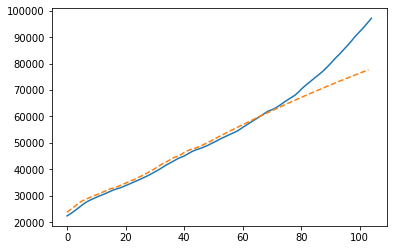

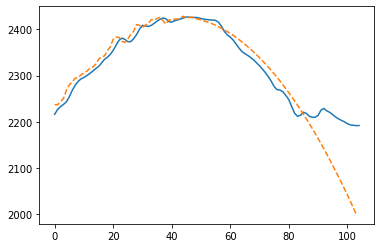

In [72]:


convert_arima('yarn')
convert_arima('express-generator')

In [67]:
# df_w = convert_week_datetime('express-generator')
df_w = convert_week_datetime('yarn')

v = df_w['downloads']
v104 = v[:104].values
ts = sm.tsa.seasonal_decompose(v104, freq=52)
seri = pd.Series(ts.trend).dropna()
print(len(v104))

104


<BarContainer object of 49 artists>

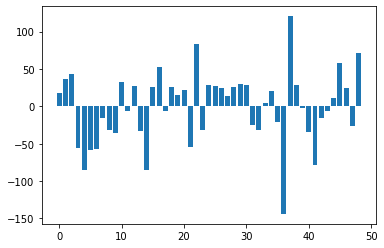

In [68]:
seri = pd.Series(seri.values)
model_d0 = ARIMA(seri, (5, 2, 1))
# 赤池なんちゃらをやったほうがいいかも
results_d0 = model_d0.fit()
res_d0 = results_d0.resid
# # 残差の出力
plt.bar(range(len(res_d0[1:])), res_d0[1:])

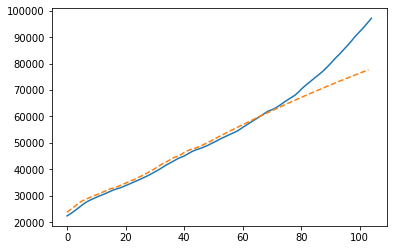

In [69]:
ts = sm.tsa.seasonal_decompose(v.values, freq=52)
gens = pd.Series(ts.trend).dropna()
gens = pd.Series(gens.values)

plt.plot(gens, label='observation')
plt.plot(results_d0.predict(2, len(gens), typ="levels").values, 
         '--', label='forecast')


In [38]:
results_d0

In [17]:
k = [-1.49283777, -1.4599206,  -1.43553526, -1.41048629, -1.38650273, -1.36304799,
 -1.33997846, -1.31721066, -1.29183494, -1.26405501, -1.234513,   -1.20597086,
 -1.18041702, -1.15397495, -1.12776921, -1.10389011, -1.08048908, -1.06333912,
 -1.05066557, -1.0314661,  -1.00804651, -0.98297053, -0.95568661, -0.92830357,
 -0.90287162, -0.87896379, -0.85258824, -0.82252028, -0.7877091,  -0.75416743,
 -0.72705308, -0.70336159, -0.67714437, -0.64534325, -0.61499754, -0.58811094,
 -0.56135151, -0.53112621, -0.50292386, -0.48587099, -0.46537928, -0.43646908,
 -0.40913074, -0.38249728, -0.35624645, -0.33012444, -0.30499109, -0.27935266,
 -0.24732316, -0.21253605, -0.1828706,  -0.15393715, -0.12211321, -0.09252632,
 -0.06193811, -0.02878588,  0.00389883,  0.03843641,  0.07536602,  0.11391066,
  0.15016588,  0.18328591,  0.21498509,  0.24624267,  0.27784464,  0.31301262,
  0.35600539,  0.39882603,  0.43669349,  0.46428461,  0.48191794,  0.50850308,
  0.54657576, 0.58565816,  0.62412884,  0.66156217,  0.69924316,  0.7406236,
  0.78313939,  0.82228294,  0.8593403,   0.8925276,   0.92941464,  0.97622255,
  1.02550946, 1.06566618 , 1.09827972,  1.13354852,  1.17758223,  1.22346988,
  1.26843863,  1.32099305,  1.36839343,  1.41063075,  1.45468962,  1.50121955,
  1.54659139,  1.59447007,  1.64445519,  1.68826189,  1.72735929,  1.76720979,
  1.81047771,  1.85568521,  1.90420733]

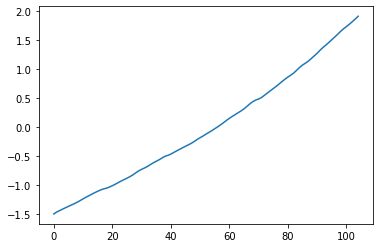

In [39]:
plt.plot(k)

In [40]:
k35 = k[:35]
a = np.array(k35)
a
b = np.split(a, 5)
b

[array([-1.49283777, -1.4599206 , -1.43553526, -1.41048629, -1.38650273,
        -1.36304799, -1.33997846]),
 array([-1.31721066, -1.29183494, -1.26405501, -1.234513  , -1.20597086,
        -1.18041702, -1.15397495]),
 array([-1.12776921, -1.10389011, -1.08048908, -1.06333912, -1.05066557,
        -1.0314661 , -1.00804651]),
 array([-0.98297053, -0.95568661, -0.92830357, -0.90287162, -0.87896379,
        -0.85258824, -0.82252028]),
 array([-0.7877091 , -0.75416743, -0.72705308, -0.70336159, -0.67714437,
        -0.64534325, -0.61499754])]

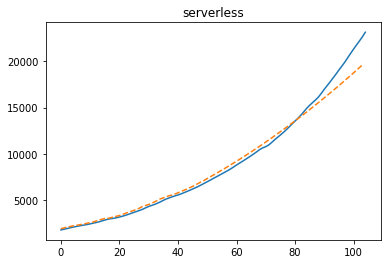

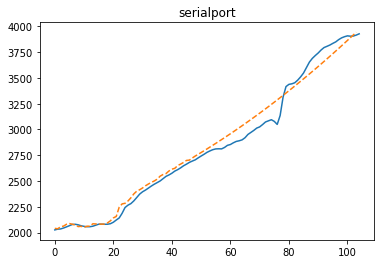

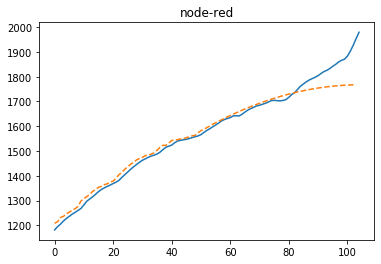

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


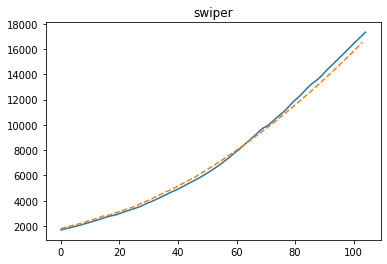

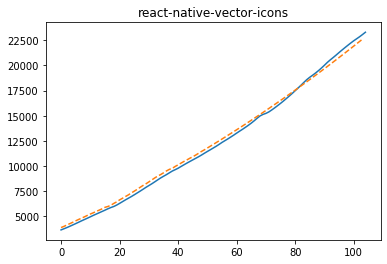

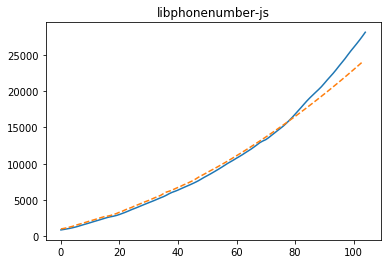

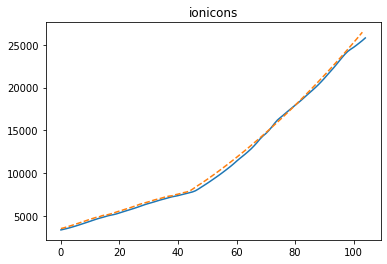

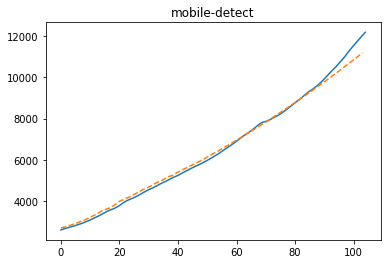

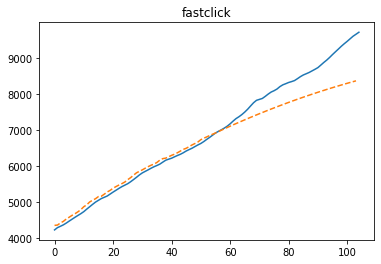

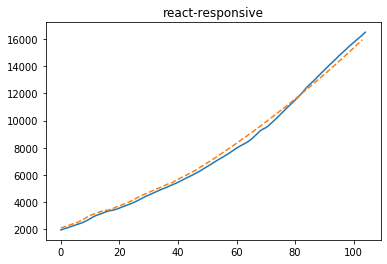

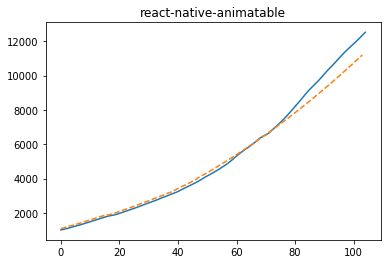

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


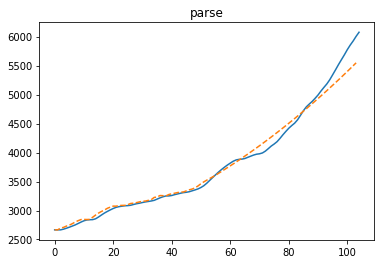

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

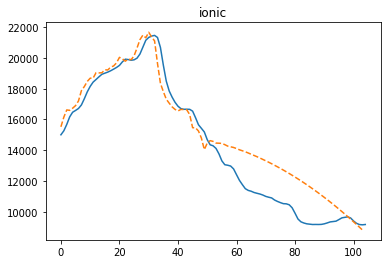

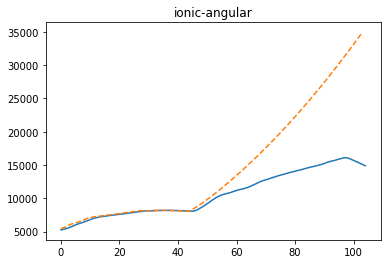

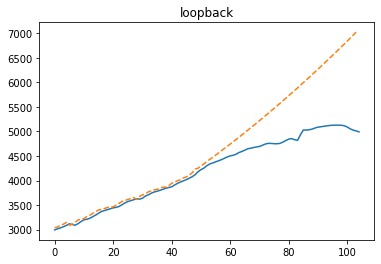

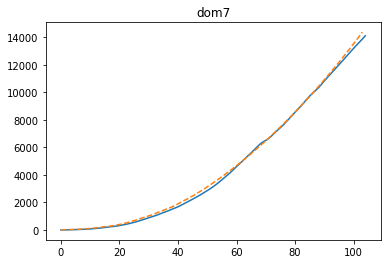

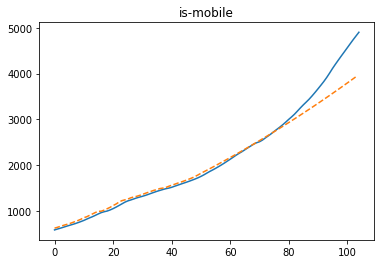

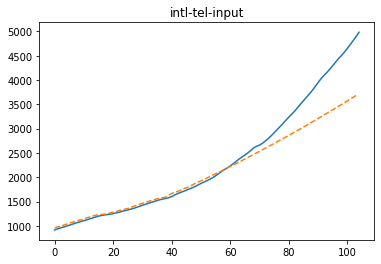

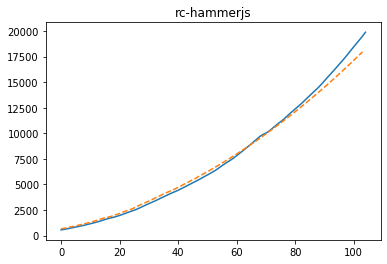

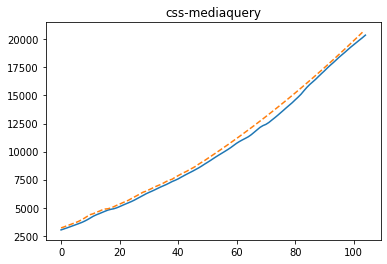

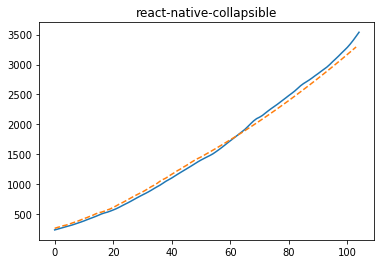

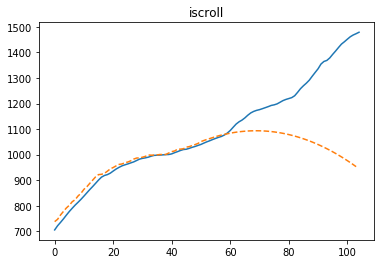

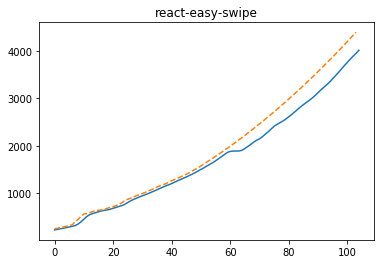

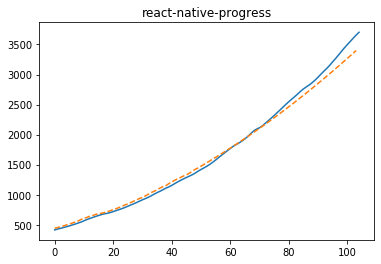

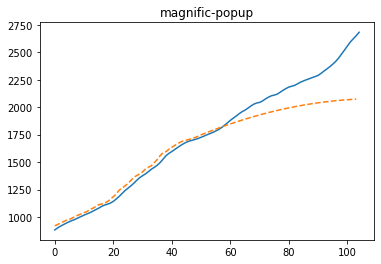

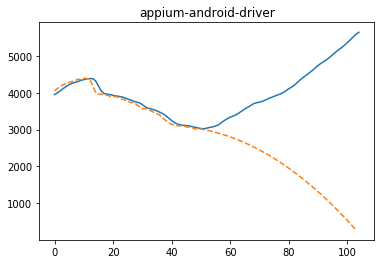

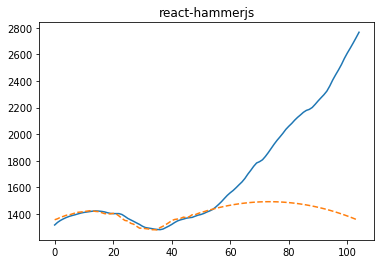

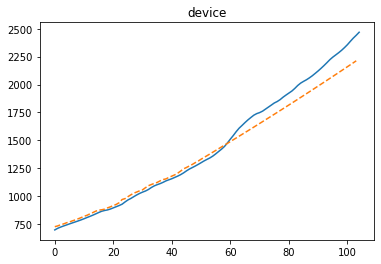

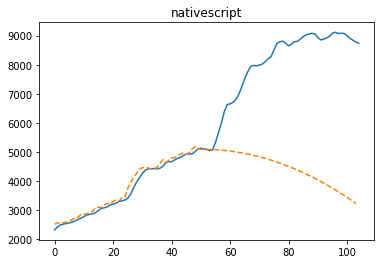

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

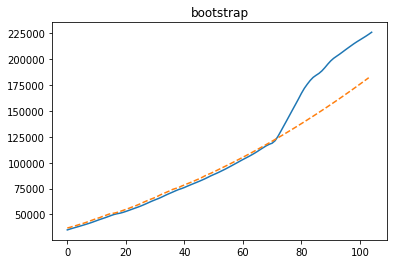

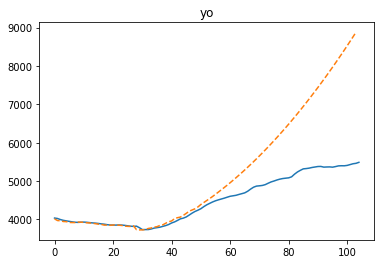

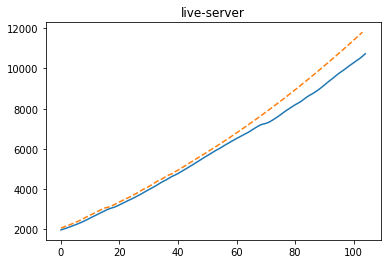

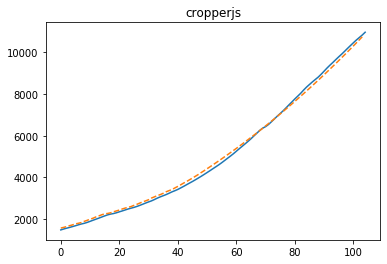

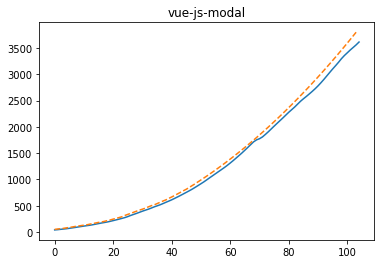

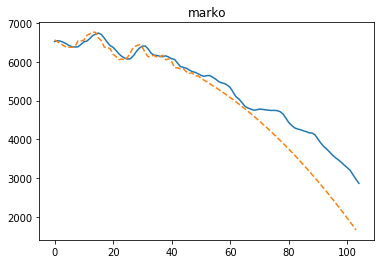

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


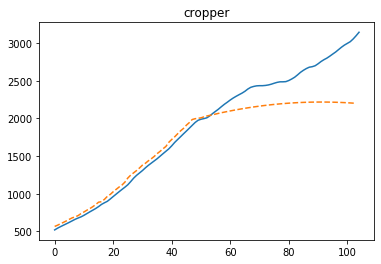

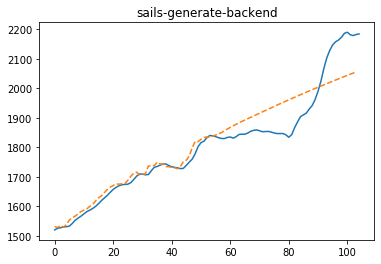

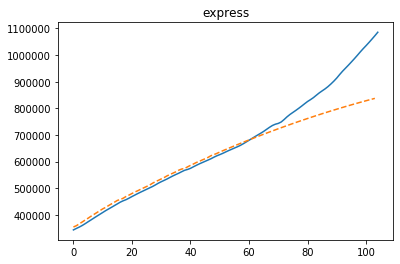

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

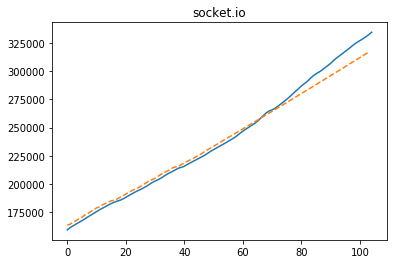

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

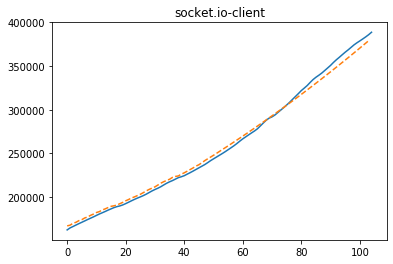

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

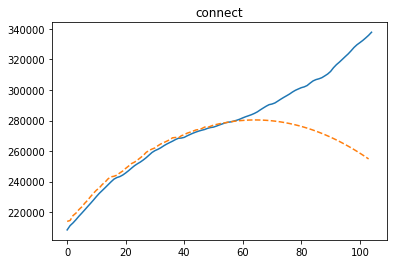

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

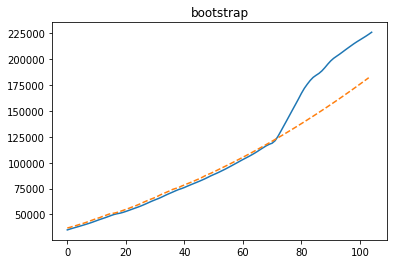

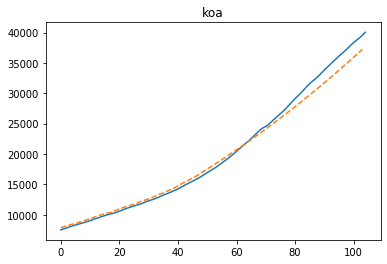

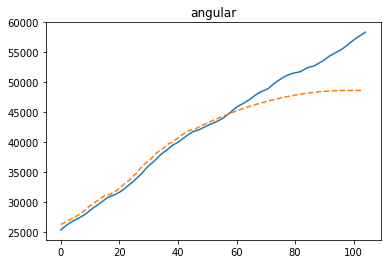

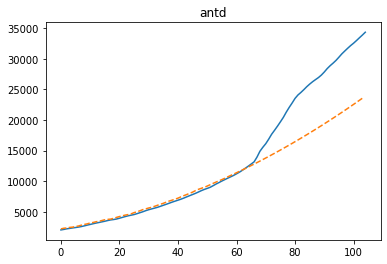

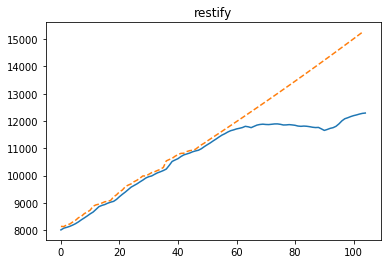

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


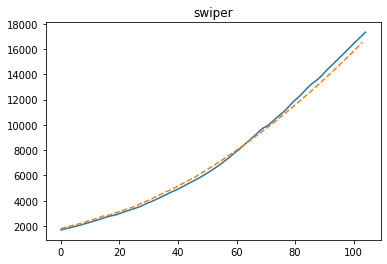

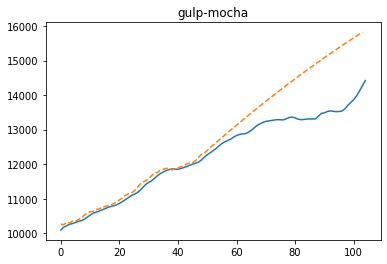

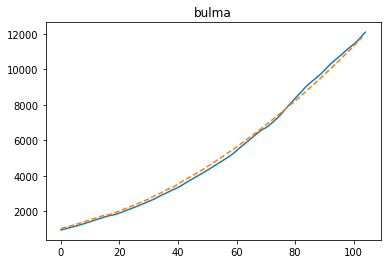

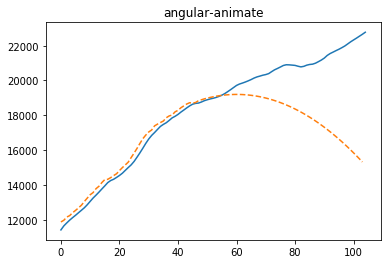

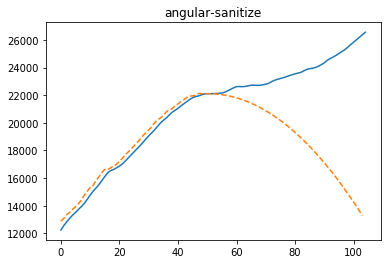

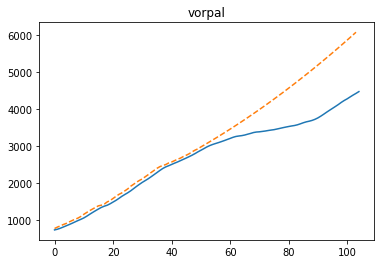

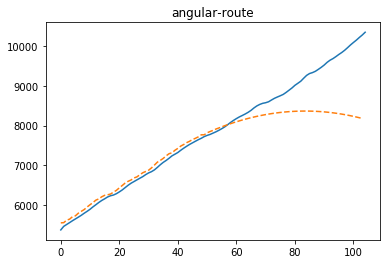

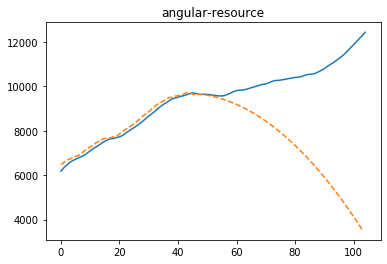

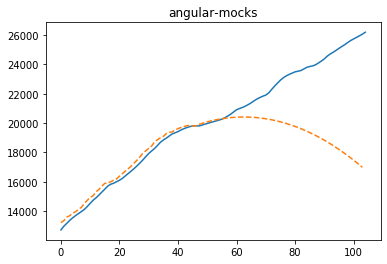

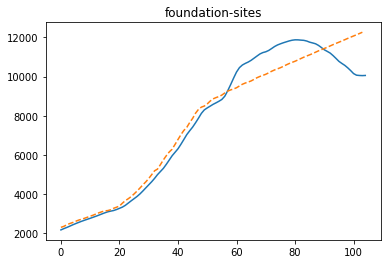

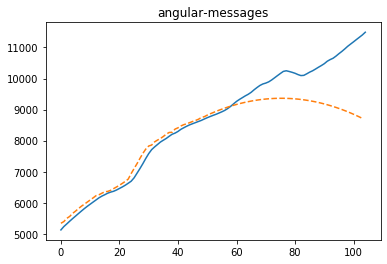

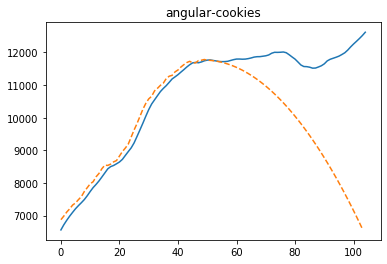

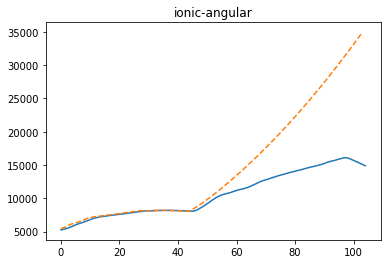

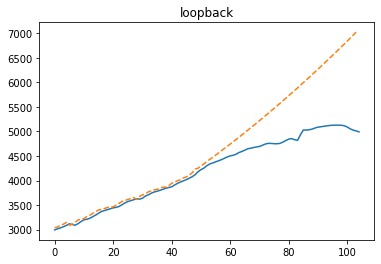

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


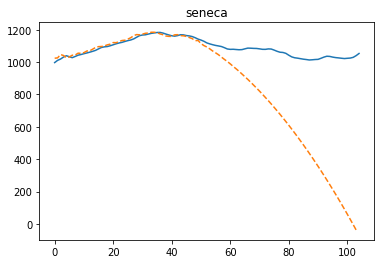

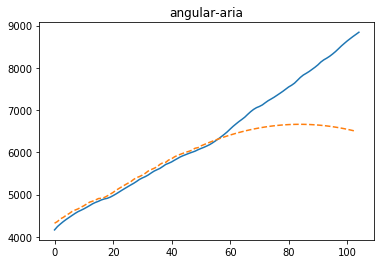

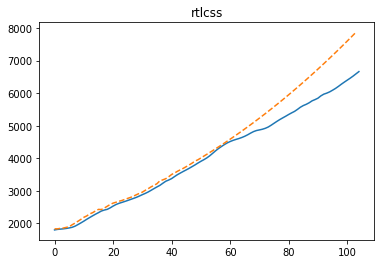

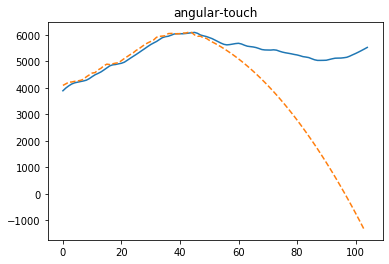

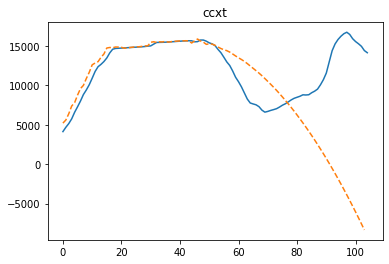

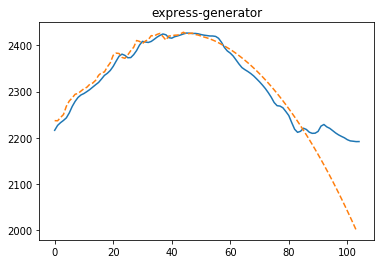

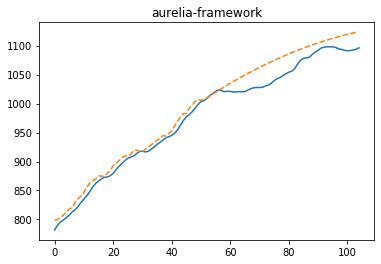

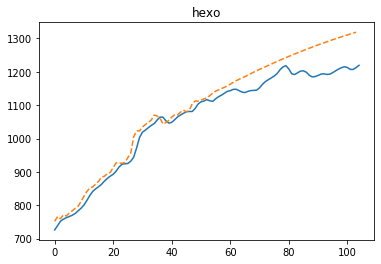

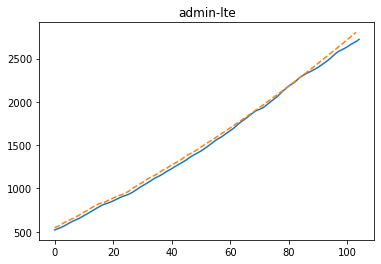

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

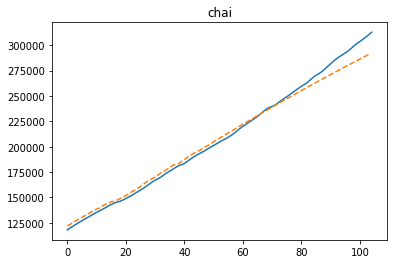

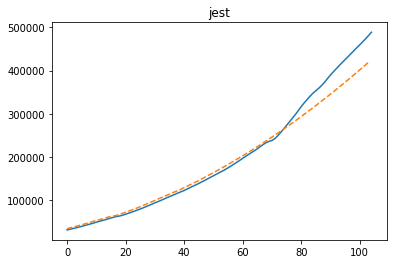

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


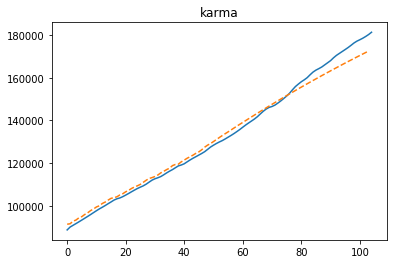

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


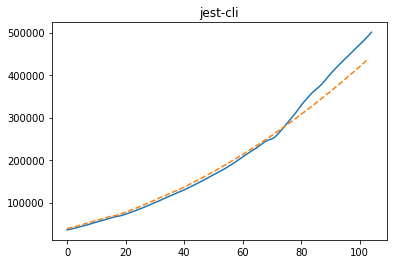

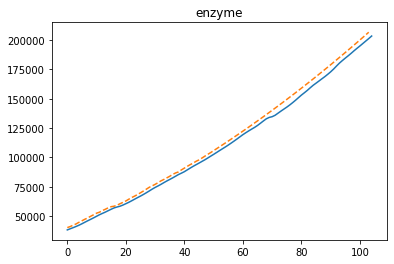

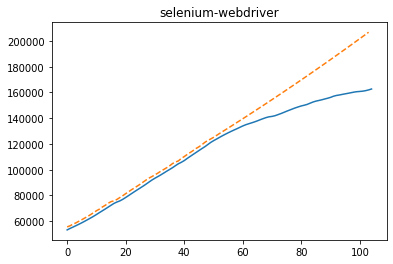

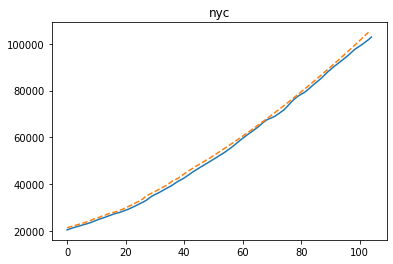

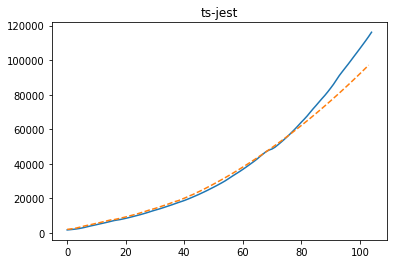

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


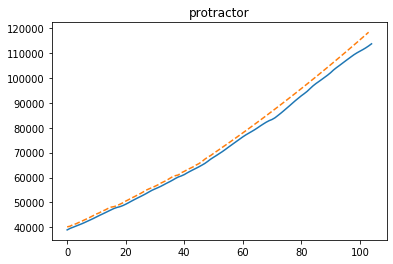

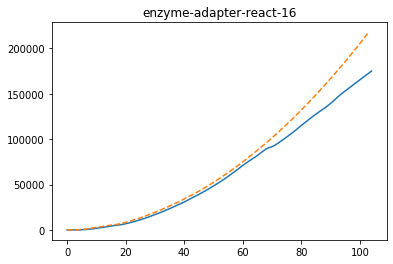

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

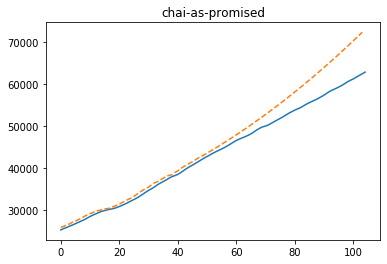

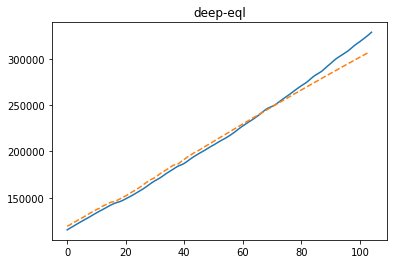

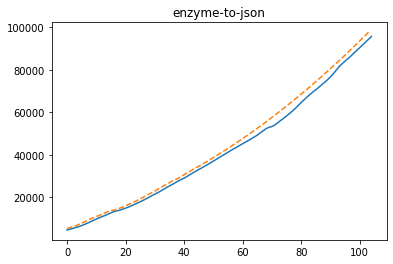

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


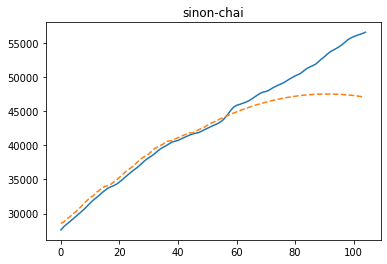

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


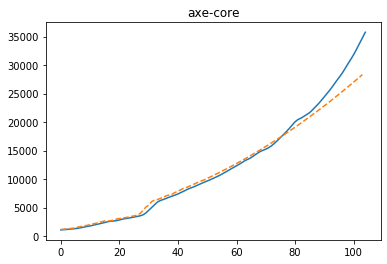

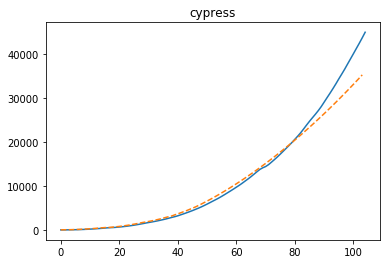

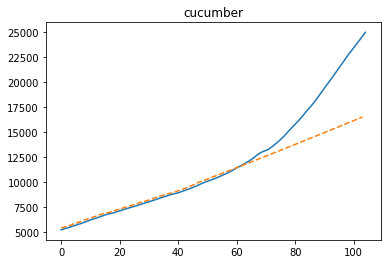

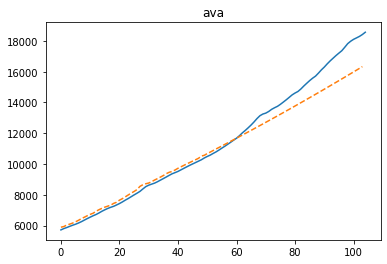

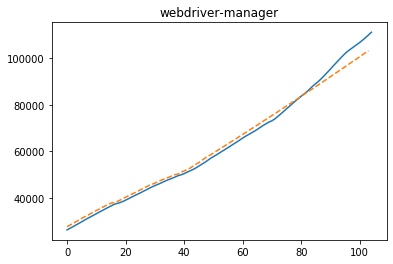

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


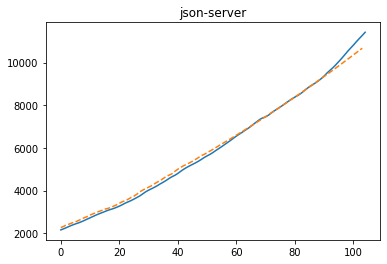

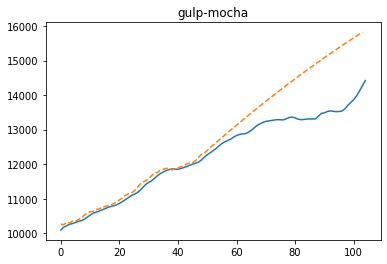

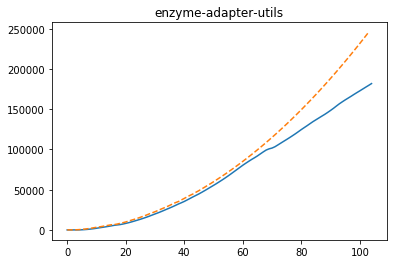

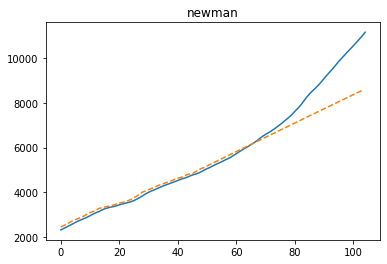

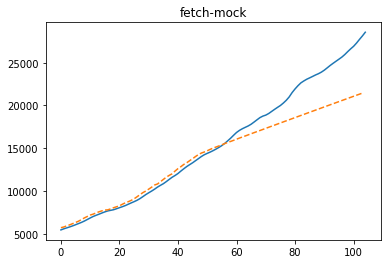

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


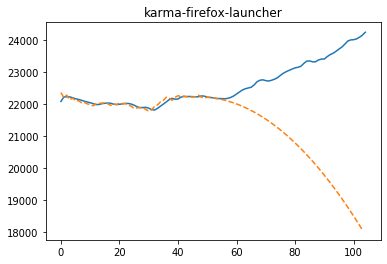

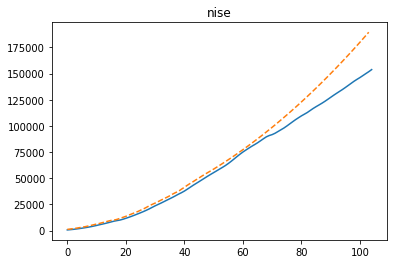

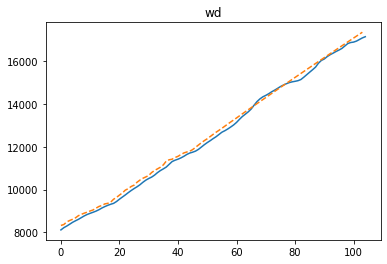

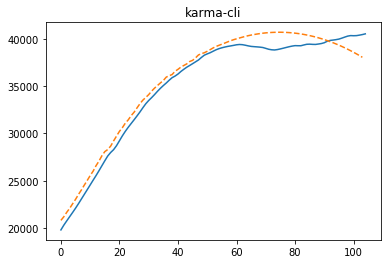

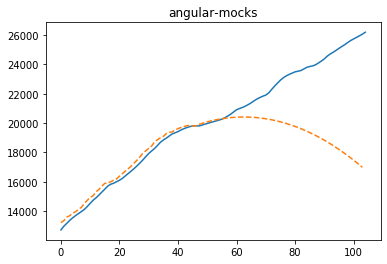

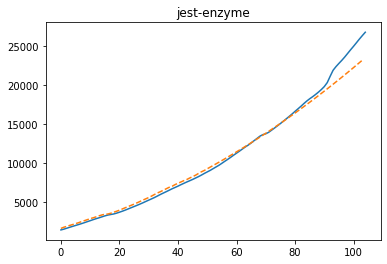

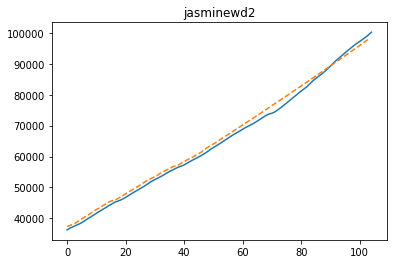

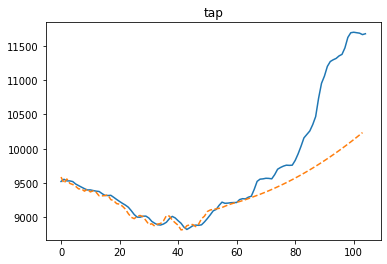

In [210]:
assets = pd.read_json('../data/assets/over1000packages.json')
for i in assets.values:
    name = i[0]
    convert_arima(name)


In [274]:
assets = pd.read_json('../data/assets/over1000packages.json')
count = 0
print('assets', len(assets.values))
for i in assets.values:
    name = i[0]
    result = is_sucess(name)
    print(result)
#     if(result.isSucess):
#         count += 1
#         print('count', count)
#         print('-------------')
# print('isS count', count)

assets 101
serverless
yarn 0.6047286817928322
104 True
actual True
predict True
is sucess True
------------------------
True
serialport
104 False
actual False
predict True
is sucess False
------------------------
False
node-red
104 False
actual False
predict False
is sucess True
------------------------
True
swiper
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predict True
is sucess True
------------------------
True
react-native-vector-icons
104 True
actual True
predict True
is sucess True
------------------------
True
libphonenumber-js
104 True
actual True
predict True
is sucess True
------------------------
True
ionicons
104 True
actual True
predict True
is sucess True
------------------------
True
mobile-detect
104 True
actual True
predict True
is sucess True
------------------------
True
fastclick
104 False
actual False
predict False
is sucess True
------------------------
True
react-responsive
104 True
actual True
predict True
is sucess True
------------------------
True
react-native-animatable
104 True
actual True
predict True
is sucess True
------------------------
True
parse
104 False
actual False
predict True
is sucess False
------------------------
False
ionic
104 False
actual False


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no b

predict False
is sucess True
------------------------
True
ionic-angular
104 False
actual False
predict True
is sucess False
------------------------
False
loopback
104 True
actual True
predict True
is sucess True
------------------------
True
dom7
104 False
actual False
predict True
is sucess False
------------------------
False
is-mobile
104 True
actual True
predict True
is sucess True
------------------------
True
intl-tel-input
104 True
actual True
predict True
is sucess True
------------------------
True
rc-hammerjs
104 True
actual True
predict True
is sucess True
------------------------
True
css-mediaquery
104 True
actual True
predict True
is sucess True
------------------------
True
react-native-collapsible
104 True
actual True
predict True
is sucess True
------------------------
True
iscroll
104 False
actual False
predict False
is sucess True
------------------------
True
react-easy-swipe
104 True
actual True
predict True
is sucess True
------------------------
True
react-nati

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

predict True
is sucess True
------------------------
True
yo
104 False
actual False
predict True
is sucess False
------------------------
False
live-server
104 True
actual True
predict True
is sucess True
------------------------
True
cropperjs
104 True
actual True
predict True
is sucess True
------------------------
True
vue-js-modal
104 False
actual False
predict True
is sucess False
------------------------
False
marko
104 False
actual False
predict False
is sucess True
------------------------
True
cropper
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predict False
is sucess False
------------------------
False
sails-generate-backend
104 False
actual False
predict True
is sucess False
------------------------
False
express
104 False
actual False
predict False
is sucess True
------------------------
True
socket.io
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

predict True
is sucess True
------------------------
True
socket.io-client
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

predict True
is sucess True
------------------------
True
connect
104 False
actual False


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

predict False
is sucess True
------------------------
True
bootstrap
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

predict True
is sucess True
------------------------
True
koa
104 True
actual True
predict True
is sucess True
------------------------
True
angular
104 True
actual True
predict False
is sucess False
------------------------
False
antd
104 True
actual True
predict True
is sucess True
------------------------
True
restify
104 True
actual True
predict True
is sucess True
------------------------
True
swiper
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predict True
is sucess True
------------------------
True
gulp-mocha
104 False
actual False
predict True
is sucess False
------------------------
False
bulma
104 True
actual True
predict True
is sucess True
------------------------
True
angular-animate
104 False
actual False
predict False
is sucess True
------------------------
True
angular-sanitize
104 False
actual False
predict False
is sucess True
------------------------
True
vorpal
104 True
actual True
predict True
is sucess True
------------------------
True
angular-route
104 True
actual True
predict False
is sucess False
------------------------
False
angular-resource
104 False
actual False
predict False
is sucess True
------------------------
True
angular-mocks
104 False
actual False
predict False
is sucess True
------------------------
True
foundation-sites
104 False
actual False
predict True
is sucess False
------------------------
False
angular-messages
104 False
actual False
predict False
is sucess True
--------------------

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predict False
is sucess True
------------------------
True
angular-aria
104 True
actual True
predict False
is sucess False
------------------------
False
rtlcss
104 True
actual True
predict True
is sucess True
------------------------
True
angular-touch
104 False
actual False
predict False
is sucess True
------------------------
True
ccxt
104 False
actual False
predict False
is sucess True
------------------------
True
express-generator
104 False
actual False
predict False
is sucess True
------------------------
True
aurelia-framework
104 False
actual False
predict False
is sucess True
------------------------
True
hexo
104 False
actual False
predict False
is sucess True
------------------------
True
admin-lte
104 True
actual True
predict True
is sucess True
------------------------
True
chai
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

predict True
is sucess True
------------------------
True
jest
104 True
actual True
predict True
is sucess True
------------------------
True
karma
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predict True
is sucess True
------------------------
True
jest-cli
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predict True
is sucess True
------------------------
True
enzyme
104 True
actual True
predict True
is sucess True
------------------------
True
selenium-webdriver
104 True
actual True
predict True
is sucess True
------------------------
True
nyc
104 True
actual True
predict True
is sucess True
------------------------
True
ts-jest
104 True
actual True
predict True
is sucess True
------------------------
True
protractor
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predict True
is sucess True
------------------------
True
enzyme-adapter-react-16
104 False
actual False
predict True
is sucess False
------------------------
False
chai-as-promised
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

predict True
is sucess True
------------------------
True
deep-eql
104 True
actual True
predict True
is sucess True
------------------------
True
enzyme-to-json
104 True
actual True
predict True
is sucess True
------------------------
True
sinon-chai
104 False
actual False


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predict False
is sucess True
------------------------
True
axe-core
104 False
actual False


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predict True
is sucess False
------------------------
False
cypress
104 False
actual False
predict True
is sucess False
------------------------
False
cucumber
104 True
actual True
predict True
is sucess True
------------------------
True
ava
104 True
actual True
predict True
is sucess True
------------------------
True
webdriver-manager
104 True
actual True
predict True
is sucess True
------------------------
True
json-server
104 True
actual True


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


predict True
is sucess True
------------------------
True
gulp-mocha
104 False
actual False
predict True
is sucess False
------------------------
False
enzyme-adapter-utils
104 False
actual False
predict True
is sucess False
------------------------
False
newman
104 True
actual True
predict True
is sucess True
------------------------
True
fetch-mock
104 True
actual True
predict True
is sucess True
------------------------
True
karma-firefox-launcher
104 False
actual False


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predict False
is sucess True
------------------------
True
nise
104 False
actual False
predict True
is sucess False
------------------------
False
wd
104 True
actual True
predict True
is sucess True
------------------------
True
karma-cli
104 False
actual False
predict False
is sucess True
------------------------
True
angular-mocks
104 False
actual False
predict False
is sucess True
------------------------
True
jest-enzyme
104 True
actual True
predict True
is sucess True
------------------------
True
jasminewd2
104 True
actual True
predict True
is sucess True
------------------------
True
tap
104 False
actual False
predict True
is sucess False
------------------------
False
